# Fine-tuning CryptoBERT Model (Sentiment Analysis)

In [42]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
import os
import sys

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/sentix_nlp"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/model"

sys.path.insert(0, ABSOLUTE_PATH)

In [44]:
!pip install --upgrade transformers

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
  AutoModelForSequenceClassification,
  AutoTokenizer,
  Trainer,
  TrainingArguments
)

from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
  classification_report,
  confusion_matrix,
  ConfusionMatrixDisplay,
  accuracy_score,
  f1_score
)


# MODEL CONSTANTS
MODEL_NAME="ElKulako/cryptobert"
NUM_LABELS=3
BATCH_SIZE=32
NUM_EPOCHS=3
LEARNING_RATE=2e-5
WEIGHT_DECAY=0.01
WARMUP_STEPS=2


## Load the model and tokenizer

In [46]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS)

### Switch to CUDA

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Load the preprocessed data

In [48]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [49]:
test_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_test.csv")
train_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_train.csv")
val_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_val.csv")

train_df = pd.read_csv(train_set_path)
val_df = pd.read_csv(val_set_path)
test_df = pd.read_csv(test_set_path)

df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df.head()

,full_text,label
0,raydium price analysis & prediction april 13 –...,2
1,us bitcoin acquisition could propel prices to ...,2
2,unveiling limits: trade representative’s bold ...,1
3,when will cardano ada break the 1 barrier?. ca...,0
4,cathie wood’s ark buys over 13m worth coinbase...,2


In [50]:
X_train, y_train = train_df['full_text'].values, train_df['label'].values
train_dataset = NewsDataset(X_train, y_train, tokenizer)

X_val, y_val = val_df['full_text'].values, val_df['label'].values
val_dataset = NewsDataset(X_val, y_val, tokenizer)

X_test, y_test = test_df['full_text'].values, test_df['label'].values
test_dataset = NewsDataset(X_test, y_test, tokenizer)

## Calculate class weights to handle imbalance

In [51]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

for i, weight in enumerate(class_weights):
    print(f"Class {i}: {weight:.4f}")

Class 0: 1.4893
Class 1: 1.2778
Class 2: 0.6469


## Training

In [52]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,
    num_train_epochs=NUM_EPOCHS,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    fp16=True,
    report_to=["tensorboard"], # no need for wandb
    logging_dir="./logs",
    logging_steps=50,
)


# REF: https://discuss.huggingface.co/t/how-can-i-use-class-weights-when-training/1067/7
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # def compute_loss(self, model, inputs, return_outputs=False):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

trainer.train()

<ipython-input-52-025ac616b4a3>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.498300,0.499270,0.807358,0.811836
2,0.339000,0.564458,0.826087,0.821650
3,0.219300,0.611404,0.824749,0.825293


TrainOutput(global_step=1122, training_loss=0.40209506624735186, metrics={'train_runtime': 404.7656, 'train_samples_per_second': 88.614, 'train_steps_per_second': 2.772, 'total_flos': 2359338016766976.0, 'train_loss': 0.40209506624735186, 'epoch': 3.0})

## Evaluate on the test set

In [53]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.5129832029342651,
 'eval_accuracy': 0.8327759197324415,
 'eval_f1': 0.8279438395663233,
 'eval_runtime': 7.6347,
 'eval_samples_per_second': 195.817,
 'eval_steps_per_second': 3.144,
 'epoch': 3.0}

In [58]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       334
           1       0.74      0.61      0.67       390
           2       0.88      0.93      0.91       771

    accuracy                           0.83      1495
   macro avg       0.81      0.80      0.80      1495
weighted avg       0.83      0.83      0.83      1495



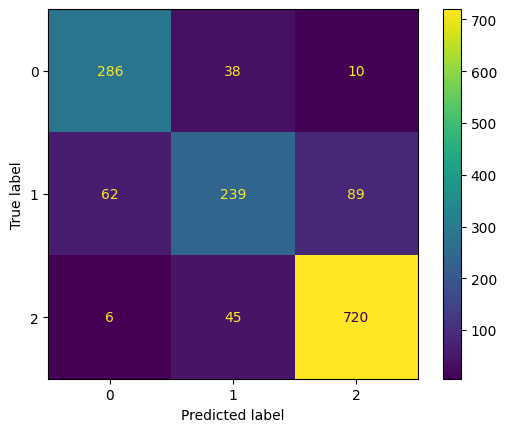

In [55]:
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()